# Home work 5: Basic Artificial Neural Networks

На семинаре вы написали нейронную сеть. Настало время ее использовать!  В этом ноутбуке вы создадите нейронную сеть и методом градиентного спуска обучите ее распознавать цифры.

В этой домашней работе вам потребуются три ноутбука: **modules.ipynb**, **main.ipynb**, с помощью которого вы сможете отладить реализацию методов в modules.ipynb, и **nn.ipynb** (этот ноутбук). Сдать нужно все три ноутбука.

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework (5 баллов)

Решите раздел backward в main.ipynb, убедитесь что все ячейки отрабатывают без ошибок и что относительная погрешность там же не превышает 1e-4 для каждого теста.

# Toy example

In [2]:
%run modules.ipynb
%load_ext autoreload
%autoreload 2

Оптимизация методом стохастического градиентного спуска уже написана за вас.

In [3]:
def sgd(x, dx, config):
    """        
        config:
            - learning_rate
    """
    
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            cur_x -=  config['learning_rate'] * cur_dx

Давайте еще раз протестируем наши модули на искуственно сгенерированной выборке.

В этом блоке вам не надо ничего реализовывать.

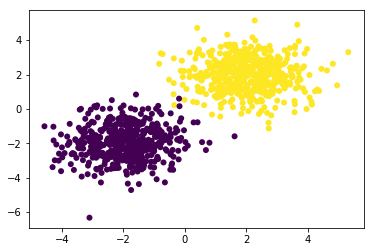

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Мы решаем задачу многоклассовой классификации с двумя классами. Истинный вектор для каждого объекта - это вектор из 0 и 1, в котором 1 стоит на том месте, какому классу принадлежит объект. Хочется чтобы сеть выдавала набор чисел, каждое из которых являлось бы степенью уверенности сети в принадлежности объекта соответствующему классу (так вектор (0.9, 0.1) означал бы что сеть считает, что объект скорее всего принадлежит нулевому классу, а не первому). Давайте зададим пару ограничений на уверенность:

1) Наша уверенность не может быть отрицательной. 

2) В сумме наша уверенность по всем объектам должна давать 1.

Набор чисел на которых выполнены эти два свойства называют распределением вероятностей.

Сеть может выдавать отрицательные числа, не говоря о том, что сумма предсказаний для объекта может быть больше единицы. Чтобы получить из произвольного набора чисел распределение вероятностей придумали функцию **SoftMax**. Её формула: $$output_i = \frac{e^{input_i}}{\sum_n e^{input_n}}.$$

Что он делает - это переводит входной вектор в вектор вероятностей (неотрицательных чисел в сумме дающих единицу).

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = MSECriterion()

print(net)

# Попробуйте что-нибудь вроде этого:

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(Sigmoid())
# net.add(Linear(4, 2))
# net.add(SoftMax())

Linear 2 -> 2
SoftMax



In [6]:
optimizer_config = {'learning_rate' : 1e-2}
optimizer_state = {}

n_epoch = 20
batch_size = 128

In [7]:
# генератор минибатчей
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # после каждой эпохи мы заново перемешиваем объекты тренировочной выборки
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Давайте обучим модель.

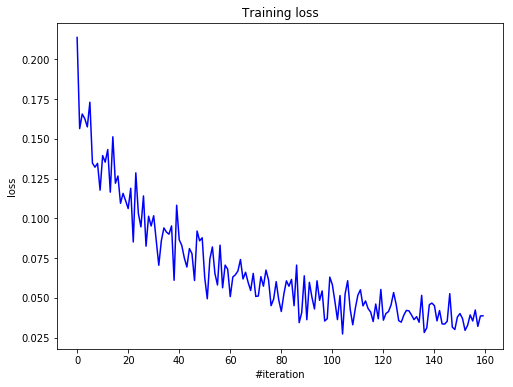

Current loss: 0.038711


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification (5 баллов)

Ваша задача - обучиться распознавать рукописные цифры из датасета MNIST.

In [28]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

def one_hot_encode(data, n_classes=10):
    n_objects = len(data)
    data_encoded = np.zeros((n_objects, n_classes))
    data_encoded[np.arange(n_objects), data.astype(int)] = 1
    return data_encoded

y = one_hot_encode(y)

In [38]:
# Попробуйте что-нибудь вроде этого:

# net = Sequential()
# net.add(Linear(784, 32))
# net.add(Sigmoid())
# net.add(Linear(32, 16))
# net.add(SoftMax())
net = Sequential()
net.add(Linear(784, 196))
net.add(Sigmoid())
net.add(Linear(196, 32))
net.add(ReLU())
net.add (Linear(32,16))
net.add(ReLU())
net.add (Linear(16,10))
net.add(SoftMax())
    
    
    
    
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # после каждой эпохи мы заново перемешиваем объекты тренировочной выборки
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

Поэкспериментируйте с разным количеством скрытых слоев, с разным размером слоев, попробуйте поменять функцию активации. По итогу напишите отчет о проведенных экспериментах который включате в себя описание того, что вы сделали, и то, какую точность по метрике mse вы смогли получить.

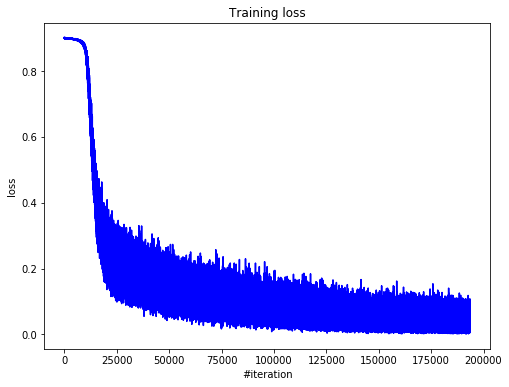

Current loss: 0.038578


KeyboardInterrupt: 

In [39]:
loss_history = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)   
# Ваш код

# Отчет

In [ ]:
"""
1 слой явно не роляет, так как это просто "усреднённое изображение буквы", что не классно, так как они 
явно по разному рисуются
решил сделать 2 слоя, чтобы первый "сжал" картинку в 4 раза, а второй уже искал серьёзные признаки
теоритически производная от ReLU= 1, а от сигмоиды всегда меньше 1, значит бэкпроп на ReLU должен быть быстрее
ReLU-ReLU = 4% ошибки на 65000 итерации
Sigmoid-Sigmoid, как и ожидалось >10% ошибки на 75000 итерации, прекращено.
Теоритически есть смысл сделать Relu-Sigmoida, чтобы ReLU спускало сильный сигнал назад а сигмоида... она мне просто нравится
Есть что то бинарное в значениях от 0 до 1
7% на ~70000. Почему то мне кажется что при большем времени на обучение у этой системы самый большой потенциал. Но..это не точно

ReLU показал себя как наиболее быстро обучаемый, решил сделать 3-слойную сеть
Потрясающе! после 45000 начал колебаться в районе 2%, возможно это максимум данной сети
Другие эксперименты ощутимых результатов не принесли

